# Opgaver til Neurale Netværk

In [181]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

np.random.seed(2024)

### Opgave 1: Low-level implementering af et feedforward neuralt netværk
I kapitel 4 i kompendiet introduceres feedforward neurale netværk. I denne opgave skal du implementere et feedforward neuralt netværk fra bunden ved hjælp af numpy. Senere i kurset vil vi bruge mere effektive biblioteker som PyTorch til at implementere neurale netværk.

#### Opgave 1.1: Initiering af et neuralt netværk
Nedenunder er givet en kode struktur for at initialisere et neuralt netværk. Udfyld de manglende linjer i koden, således at netværket kan initialiseres med de ønskede antal lag og antal neuroner i hvert lag. Vi antager at alle neuroner skal initieres med tilfældige vægte.

For at afprøve din implementering, skal du bede den endelige kode om at initialisere netværket vist i figur 4.2 i kompendiet. Dette netværk har 2 lag, hvor det første lag har 3 neuroner, og det andet lag har 1 neuron. H

In [56]:
def init_vægte(dim_in: int, dim_out: int):
    W = np.random.randn(dim_in, dim_out)
    b = np.random.randn(dim_out)
    return W, b

def init_NN(X_dim: int, L: list[int]):
    vægte = []
    bias = []

    for i, lag in enumerate(L):
        if i == 0:
            W, b = init_vægte(X_dim, lag)
        else:
            W, b = init_vægte(L[i-1], lag)
        vægte.append(W)
        bias.append(b)

    return vægte, bias

Netværket har 2 lag, med hhv. 2 neuroner i lag (1), 1 neuroner i lag (2)

W^(1):
[[ 0.80376666  1.79803017]
 [ 0.48264309 -0.29500847]
 [ 1.10023553  0.61361159]]
b^(1):
[ 0.4737437  -0.91134699]

W^(2):
[[0.86435481]
 [1.17813709]]
b^(2):
[-0.74836836]



In [ ]:
def print_NN_params(vægte: list, biases: list):
    print(f"Netværket har {len(vægte)} lag, med hhv. {', '.join([f'{vægte[i].shape[1]} neuroner i lag ({i+1})' for i in range(len(vægte))])}")
    print()
    for i, (vægt, bias) in enumerate(zip(vægte, biases)):
        print(f'W^({i+1}):')
        print(vægt)
        print(f'b^({i+1}):')
        print(bias)
        print()

print_NN_params(*init_NN(X_dim=3, L = [2, 1]))

#### Opgave 1.2: Aktiveringsfunktioner
Nedenfor er givet en kode struktur for at implementere nogle af de mest almindelige aktiveringsfunktioner. Udfyld de manglende linjer i koden, således at aktiveringsfunktionerne kan bruges i netværket. Når du mener du har implementeret aktiveringsfunktionerne korrekt, kan du prøve at sammenligne dine resultat-plots i bunden med plotsne i figur XX i kompendiet. Ligner dine plots dem i kompendiet?

*Hint: Hvis du har brug for hjælp til at implementere aktiveringsfunktionerne, kan du kigge i kapitel 4 i kompendiet.*

In [97]:
def ReLu(z: np.ndarray) -> np.ndarray:
    return np.maximum(0, z) # TODO: Implementer ReLu

def tanh(z: np.ndarray) -> np.ndarray:
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z)) # TODO: Implementer tanh

def sigmoid(z: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-z)) # TODO: Implementer sigmoid

def leaky_ReLu(z: np.ndarray, alpha: float = 0.1) -> np.ndarray:
    return np.maximum(alpha * z, z) # TODO: Implementer leaky ReLu

def softmax(z: np.ndarray) -> np.ndarray:
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True) # TODO: Implementer softmax

In [ ]:
aktiverings_funktioner = [tanh, sigmoid, ReLu, leaky_ReLu]
fig, ax = plt.subplots(1, len(aktiverings_funktioner), figsize=(15, 4), sharey=True, layout='tight')
ax[0].set_ylabel('$f(z)$')
z = np.linspace(-5, 5, 100).reshape(-1, 1)
for i, f in enumerate(aktiverings_funktioner):
    ax[i].plot(z, f(z))
    ax[i].set_title(f.__name__)
    ax[i].plot(z, np.zeros_like(z), 'k--', linewidth=0.5)
    ax[i].plot(np.zeros_like(z), z, 'k--', linewidth=0.5)
    ax[i].set_ylim([-2, 2])
    ax[i].set_xlim([-5, 5])
    ax[i].grid(True)
    ax[i].set_xlabel('$z$')
plt.show()

#### Opgave 1.3: Forward pass
Vi er nu klar til at koble netværket sammen. I kompendiet benævnte vi grunden bag at feed forward netværk hedder feed forward; Informationen rejser forward igennem netværket. Nedenfor er givet en kode struktur for at implementere et **forward pass** i et neuralt netværk. Udfyld de manglende linjer i koden, således at forward pass kan udføres. Når du mener du har implementeret forward pass korrekt, kan du prøve at køre understående kode, der initialisere et netværk og benytter de forskellige aktiveringsfunktioner og udfører et forward pass med inputtet

$$\mathbf{X}=\begin{bmatrix} 0.5 & 0.1 \\ 0.4 & 2.1 \\ -1.0 & -0.8 \\ 0.6 & -1.9 \end{bmatrix}$$

Hvilket output får du? Hvis du tænker over dimensionerne på inputtet, dimensionerne på outputtet og de forskellige aktiveringsfunktioner, kan du så forklare hvorfor du får det output du får og hvad outputtet fortæller dig?

In [114]:
def forward(X: np.ndarray, vægte: list, biases: list, aktiverings_funks: list) -> np.ndarray:
    a = X
    for i, (W, b, f) in enumerate(zip(vægte, biases, aktiverings_funks)):
        z = np.dot(a, W) + b
        a = f(z)
    return a

In [154]:
X = np.array([[0.2, 0.8], [2.5, 3], [0.3, -0.9],[4, 3.5]]) # faglig todo, overvej om det er en god ide at bruge denne data
vægte, biases = init_NN(X_dim=2, L=[3, 3, 3, 3, 2])
fs = [tanh, ReLu, leaky_ReLu, ReLu, softmax]
print(forward(X, vægte, biases, fs))

[[0.89368051 0.10631949]
 [0.88041252 0.11958748]
 [0.91334609 0.08665391]
 [0.88603846 0.11396154]]


#### Opgave 1.4: Klassifikation
I denne opgave skal du implementere en klassifikationsfunktion, som kan bruges til at klassificere outputtet fra netværket. Koden er givet nedenfor. Udfyld de manglende linjer i koden, således at klassifikationsfunktionen kan bruges til at klassificere outputtet fra netværket. Når du mener du har implementeret klassifikationsfunktionen korrekt, kan du prøve at køre koden derunder. Hvilke af de fire datapunkter i $\mathbf{X}$ klassificeres som klasse 1 og hvilke klassificeres som klasse 2?

In [155]:
def get_label(prob: np.ndarray) -> np.ndarray:
    return np.argmax(prob, axis=1)

Klassifikation: [0 0 0 0]


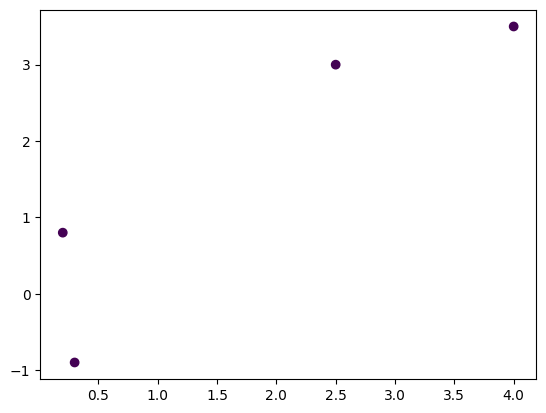

In [162]:
y_prob = forward(X, vægte, biases, fs)
y = get_label(y_prob)
print(f"Klassifikation: {y}")
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

Ikke overraskende er det neurale netværk ikke særlig god til at klassificere data, da vi ikke har trænet netværket endnu. I næste opgave skal vi træne netværket.

#### Opgave 1.4: Loss funktion
For at kunne træne netværket, må vi starte med at implementere loss functionen. Nedenfor er givet en kode struktur for at implementere en loss funktion. Udfyld de manglende linjer i koden, således at loss funktionen kan bruges i netværket. Når du mener du har implementeret loss funktionen korrekt, kan du prøve at køre koden derunder. Hvilken loss får du for vores tidligere prædiktioner?

In [169]:
def E(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return -np.sum([np.sum(y_true[i] * np.log(y_pred[i])) for i in range(y_true.shape[0])])

In [170]:
E(np.array([0, 1, 0, 1]), y_prob)

4.543961007756647

#### Opgave 1.5: Backward pass

I denne opgave skal du implementere et **backward pass** i netværket. Nedenfor er givet en kode struktur for at implementere et backward pass. Udfyld de manglende linjer i koden, således at backward pass kan udføres. Når du mener du har implementeret backward pass korrekt, kan du prøve at køre koden derunder. Hvilke værdier får du for $\mathbf{dW1}$ og $\mathbf{dW2}$?

In [ ]:
## TODO - Implementer backpropagation

#### Opgave 1.6: Fuldt eksempel

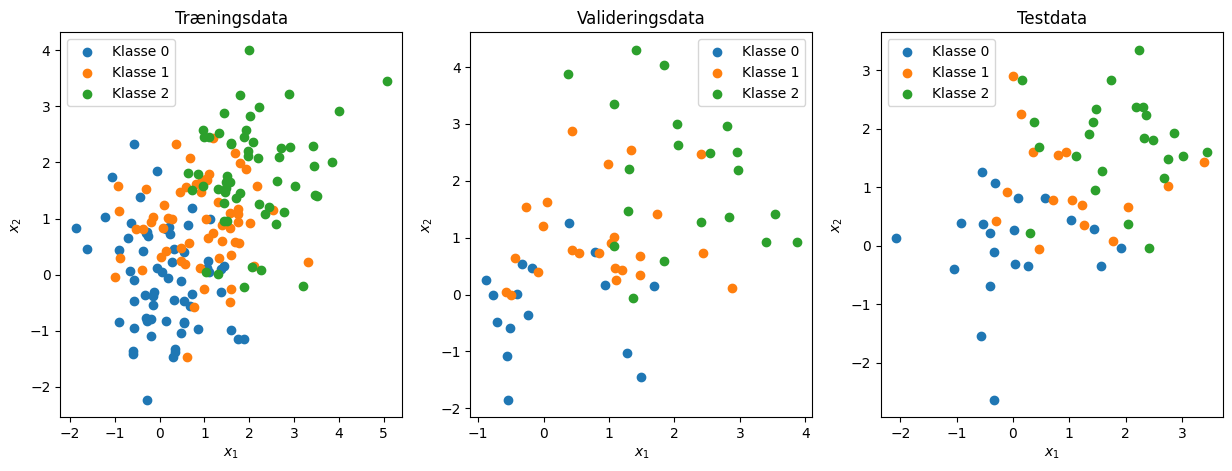

In [204]:
def data_generator(n_datapunkter: int = 300, n_klasser: int = 3, n_dim: int = 2, støj: float = 0.9):
    for klasse in range(n_klasser):
        X_ = np.random.normal(klasse, støj, (n_datapunkter // n_klasser, n_dim))
        y_ = np.full(X_.shape[0], klasse)
        if klasse == 0:
            X = X_
            y = y_
        else:
            X = np.vstack([X, X_])
            y = np.hstack([y, y_])

    idx = np.random.permutation(X.shape[0])
    X, y = X[idx], y[idx]
    X_train, y_train = X[:int(0.6 * X.shape[0])], y[:int(0.6 * X.shape[0])]
    X_val, y_val = X[int(0.6 * X.shape[0]):int(0.8 * X.shape[0])], y[int(0.6 * X.shape[0]):int(0.8 * X.shape[0])]
    X_test, y_test = X[int(0.8 * X.shape[0]):], y[int(0.8 * X.shape[0]):]
    return X_train, y_train, X_val, y_val, X_test, y_test  

def plot_data(X: np.ndarray, y: np.ndarray, axs: plt.Axes = None):
    if axs is None:
        fig, axs = plt.subplots(1, 1, figsize=(5, 5))
    for klasse in np.unique(y):
        axs.scatter(X[y == klasse, 0], X[y == klasse, 1], label=f'Klasse {klasse}')
    axs.legend()

X_train, y_train, X_val, y_val, X_test, y_test = data_generator()
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, x, y in zip(range(3), [X_train, X_val, X_test], [y_train, y_val, y_test]):
    plot_data(x, y, ax[i])
    ax[i].set_title(['Træningsdata', 'Valideringsdata', 'Testdata'][i])
    ax[i].set_xlabel('$x_1$')
    ax[i].set_ylabel('$x_2$')
plt.show()

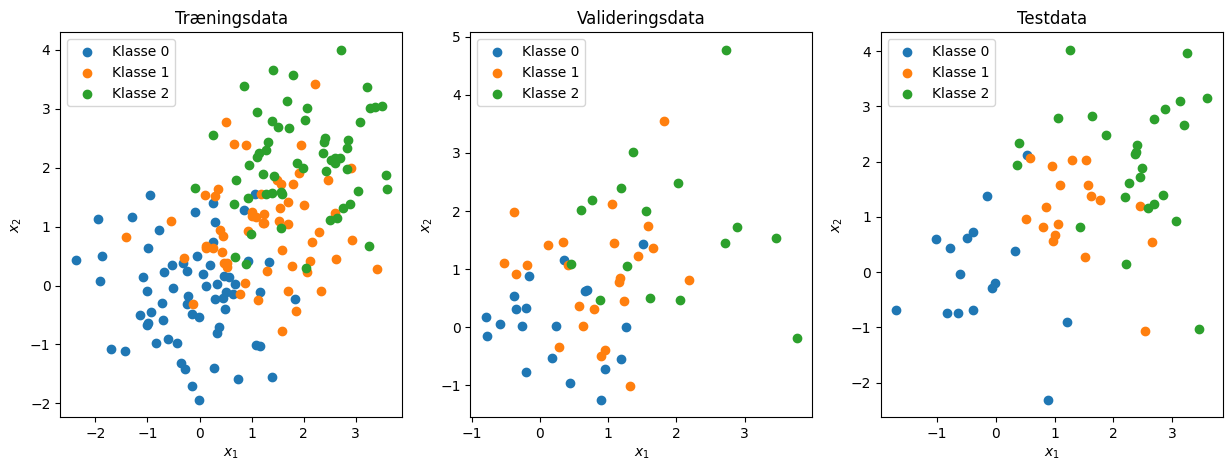

In [203]:
X_dim = X_train.shape[1]
L = [10, 10, 10, 3]
vægte, biases = init_NN(X_dim, L)
fs = [ReLu, leaky_ReLu, ReLu, softmax]


### Opgave 2: Implementering af et neuralt netværk med PyTorch

Det ovenstående eksempel var en god øvelse i at forstå hvordan neurale netværk fungerer, men i praksis vil vi ofte bruge mere effektive biblioteker til at implementere neurale netværk. I denne opgave skal du implementere det samme neurale netværk med PyTorch. Du skal bruge PyTorch til at initialisere et neuralt netværk, udføre et forward pass, beregne loss, udføre et backward pass og opdatere vægtene i netværket. Du skal bruge PyTorch til at initialisere et neuralt netværk, udføre et forward pass, beregne loss, udføre et backward pass og opdatere vægtene i netværket.

In [213]:
X_train, y_train = torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long()
X_val, y_val = torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long()
X_test, y_test = torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long()

In [220]:
#Hyperparameters
num_classes = y_train.unique().shape[0]
L = [3, 3, 2, num_classes]
num_features = X_train.shape[1]

# define network
class Net(nn.Module):
    def __init__(self, num_features, L):
        super(Net, self).__init__()
        self.Ws = []
        self.bs = []
        self.aktivering = []
        for i, lag in enumerate(L):
            if i == 0:
                self.Ws.append(Parameter(init.normal_(torch.randn(num_features, lag), std=1)))
                self.bs.append(Parameter(init.constant_(torch.randn(lag), 0)))
                self.aktivering.append(F.relu)
            else:
                self.Ws.append(Parameter(init.normal_(torch.randn(L[i-1], lag), std=1)))
                self.bs.append(Parameter(init.constant_(torch.randn(lag), 0)))
                self.aktivering.append(F.relu)
        
        # get parameters lists
        self.Ws = nn.ParameterList(self.Ws)
        self.bs = nn.ParameterList(self.bs)

    def forward(self, x):
        for W, b, f in zip(self.Ws, self.bs, self.aktivering):
            x = f(F.linear(x, W, b))
        return x

net = Net(num_features, L)

In [221]:
list(net.parameters())

[]

In [215]:
optimizer = optim.Adam(net.parameters(), weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()

hyperparams = {'num_epochs': 100, 'batch_size': 100, 'learning_rate': 1e-3}

num_samples_train = X_train.shape[0]
num_batches_train = num_samples_train // hyperparams['batch_size']
num_samples_val = X_val.shape[0]
num_batches_val = num_samples_val // hyperparams['batch_size']

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(hyperparams['num_epochs']):
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, hyperparams['batch_size'])
        X_batch = Variable(X_train[slce])
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(y_train[slce])
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / hyperparams['batch_size'])

    net.eval()
    
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, hyperparams['batch_size'])
        X_batch = Variable(X_train[slce])
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(y_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_val):
        slce = get_slice(i, hyperparams['batch_size'])
        x_batch = Variable(torch.from_numpy(X_val[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(y_val[slce])

    train_acc_cur = torch.sum(train_targs == train_preds).item() / train_targs.shape[0]
    valid_acc_cur = torch.sum(val_targs == val_preds).item() / val_targs.shape[0]
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

ValueError: optimizer got an empty parameter list

In [212]:
y_t = torch.tensor([0, 1, 0, 1])
y_p = torch.tensor([0, 1, 1, 0])

# get accuracy
acc = torch.sum(y_t == y_p).item() / y_t.shape[0]

0.5